## Filtros FIR-LS con registro finito: Método de Covarianza

El objetivo del método **FIR-LS (Least Squares)** es ajustar un filtro FIR de orden $L-1$ que minimice el error entre una señal deseada $d(n)$ y una señal generada a partir de otra señal $x(n)$ filtrada por $h(n)$. La salida estimada del sistema es:

$$
\hat{d}(n) = \sum_{k=0}^{L-1} h(k) \, x(n - k)
$$

El error entre la señal deseada y la salida estimada es:

$$
e(n) = d(n) - \hat{d}(n) = d(n) - \sum_{k=0}^{L-1} h(k) \, x(n - k)
$$

El criterio de optimización es la minimización de la energía del error:

$$
\mathcal{E}(\mathbf{h}) = \sum_{n=i_0}^{i_f} |e(n)|^2
$$

Los límites $i_0$ e $i_f$ se eligen para que todas las muestras de $x(n-k)$ y $d(n)$ estén disponibles. La solución óptima del filtro FIR para minimizar el error cuadrático se obtiene resolviendo el sistema de ecuaciones normales:

$$
\frac{\partial \mathcal{E}}{\partial h(k)}
\sum_{n=i_0}^{i_f} e(n)\,\frac{\partial x^*(n)}{\partial h(k)} =
\sum_{n=i_0}^{i_f} e(n)\,x^*(n - k) = 0
$$

$$
\begin{aligned}
        \sum_{n=i_0}^{i_f}\left[ d(n) - \sum_{n=l}^{L-1}h(l)x(n-l)\right]x^*(n-k) &=0  \\
        \sum_{n=i_0}^{i_f} d(n) x^*(n-k) &= \sum_{n=l}^{L-1} h(l) \cdot \sum_{n=i_0}^{i_f} x(n-l) x^*(n-k) 
\end{aligned}
$$
$$
       \boxed{\sum_{n=i_0}^{i_f} d'(n-n_0) x^*(n-k) = \sum_{n=l}^{L-1} h(l) \cdot \sum_{n=i_0}^{i_f} x(n-l) x^*(n-k)} 
$$
Matricialmente:
$$
\mathbf{R}_x \, \mathbf{h} = \mathbf{r}_{dx}
$$
donde
$$
\mathbf{X}_{i_0} =
\begin{bmatrix}
x(i_0) & x(i_0 - 1) & \cdots & x(i_0 - L + 1) \\
x(i_0 + 1) & x(i_0) & \cdots & x(i_0 - L + 2) \\
\vdots & \vdots & \ddots & \vdots \\
x(i_f) & x(i_f - 1) & \cdots & x(i_f - L + 1)
\end{bmatrix}
\qquad \qquad \text{y}\qquad \qquad \mathbf{d}_{i_0} =
\begin{bmatrix}
d(i_0) \\
d(i_0 + 1) \\
\vdots \\
d(i_f)
\end{bmatrix}
$$
Entonces:
- $\mathbf{R}_x = \mathbf{X}_{i_0}^H \mathbf{X}_{i_0}$
- $\mathbf{r}_{dx} = \mathbf{X}_{i_0}^H \mathbf{d}_{i_0}$

El valor mínimo de la energía del error se puede expresar como:

$$
\mathcal{E}_{\min} = \|\mathbf{d}_{i_0}\|^2 - \sum_{k=0}^{L-1} h(k) \, r_{dx}^*(k) \qquad \longrightarrow \qquad \mathcal{E}_{\min} = r_d(0, 0) - \sum_{k=0}^{L-1} h(k) \, r_{dx}^*(k)
$$
donde:
$$
r_d(0, 0) = \sum_{n = i_0}^{i_f} |d(n)|^2 = \|\mathbf{d}_{i_0}\|^2
$$

Este método no impone ninguna suposición sobre los datos fuera del intervalo de observación, a diferencia del método de autocorrelación. Es por tanto más adecuado en condiciones de ventana finita, especialmente en aplicaciones prácticas como el diseño de filtros adaptativos o estimación de sistemas.

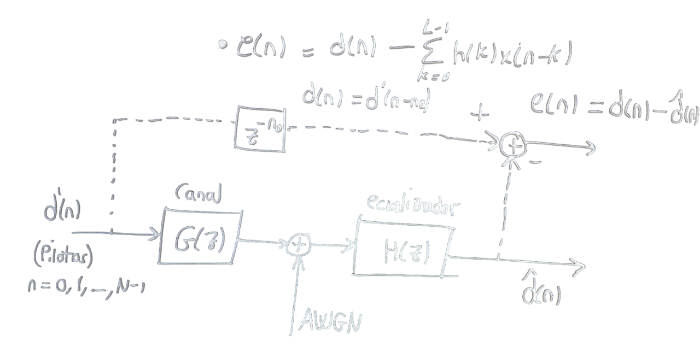

In [26]:
%reset


import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import write
from scipy.linalg import toeplitz  # comando de generacion matrices Toeplitz
from scipy.linalg import inv  # comando de inversion de matrices
from macros import *


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 1</h1>

<hr style="border: 1.5px solid orange;">

Se comprobará el funcionamiento del ecualizador para valores de retardo $n_0 = 0, 1, \dots, L-1$, obteniendo en cada caso el error cuadrático directo y el _bit error rate_ (**BER**). Dibujar en una misma gráfica el error cuadrático (promediado al número de muestras) y el BER en función del retardo $n_0$. Seleccionar el valor de $n_0$ óptimo.

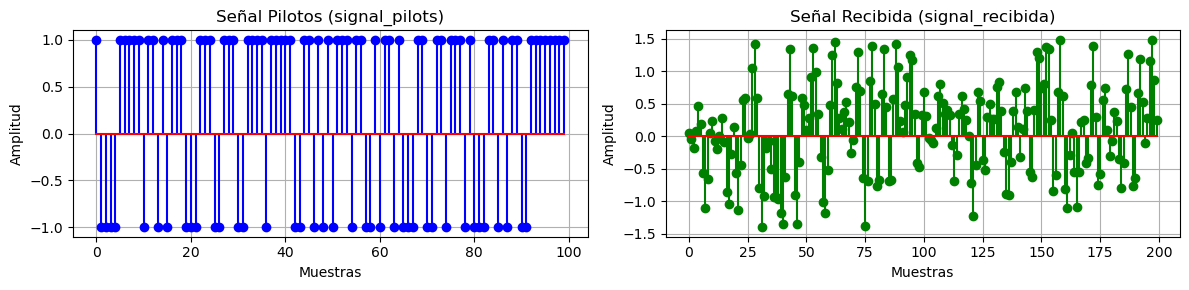

In [64]:

# Cargar los archivos .npy
signal_pilots = np.load('data/signal_pilots.npy')
signal_recibida = np.load('data/signal_recibida.npy')


#! Representación gráfica de las señales en forma discreta
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1) #? Graficar signal_pilots
plt.stem(signal_pilots, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title("Señal Pilotos (signal_pilots)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()

plt.subplot(1, 2, 2) #? Graficar signal_recibida
plt.stem(signal_recibida, linefmt='g-', markerfmt='go', basefmt='r-')
plt.title("Señal Recibida (signal_recibida)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()

plt.tight_layout()
plt.show()




ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 50 is different from 100)

<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 2</h1>

<hr style="border: 1.5px solid orange;">

Sabiendo que el canal $G(z)$ es IIR de orden 3 y que tiene los siguientes coeficientes en su numerador (coeficientes **b**) y su denominador (coeficientes **a**):

```text
b = [0.06366198, -0.12349588, 0.05611536, 0.23689969]
a = [1.0, -2.93711362, 3.06181384, -1.15303739, 0.28529261]
```

Razonar si sería viable la ecualización empleando el filtro inverso $G^{-1}(z)$.

<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 3</h1>

<hr style="border: 1.5px solid orange;">

Para el retardo óptimo, dibujar las respuestas en frecuencia (magnitud y fase) del canal, del ecualizador, y del conjunto (cascada) canal + ecualizador.